# Импорт библиотек

In [9]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from etna.datasets.tsdataset import TSDataset
from etna.models import NaiveModel
from etna.metrics import MAPE
from etna.metrics import SMAPE
from etna.analysis import plot_forecast
# from etna.models import ProphetModel
from etna.transforms import LagTransform
from etna.models import CatBoostMultiSegmentModel
import matplotlib.pyplot as plt

# Загрузка данных и первичный анализ

In [2]:
df = pd.read_csv('data/prices_hist.csv')
df.head()

,datetime,price
0,2018-01-05,36550.0
1,2018-01-12,36850.0
2,2018-01-19,36850.0
3,2018-01-26,35200.0
4,2018-02-02,34650.0


In [3]:
df["timestamp"] = pd.to_datetime(df["datetime"])
df["target"] = df["price"]
df.drop(columns=["datetime", "price"], inplace=True)
df["segment"] = "main"
df.head()

,timestamp,target,segment
0,2018-01-05,36550.0,main
1,2018-01-12,36850.0,main
2,2018-01-19,36850.0,main
3,2018-01-26,35200.0,main
4,2018-02-02,34650.0,main


In [4]:
df = TSDataset.to_dataset(df)
df.head()

segment,main
feature,target
timestamp,
2018-01-05,36550.0
2018-01-12,36850.0
2018-01-19,36850.0
2018-01-26,35200.0
2018-02-02,34650.0


In [5]:
ts = TSDataset(df, freq="W-FRI")
ts.describe()

,start_timestamp,end_timestamp,length,num_missing,num_segments,num_exogs,num_regressors,num_known_future,freq
segments,,,,,,,,,
main,2018-01-05,2022-12-30,261,0,1,0,0,0,W-FRI


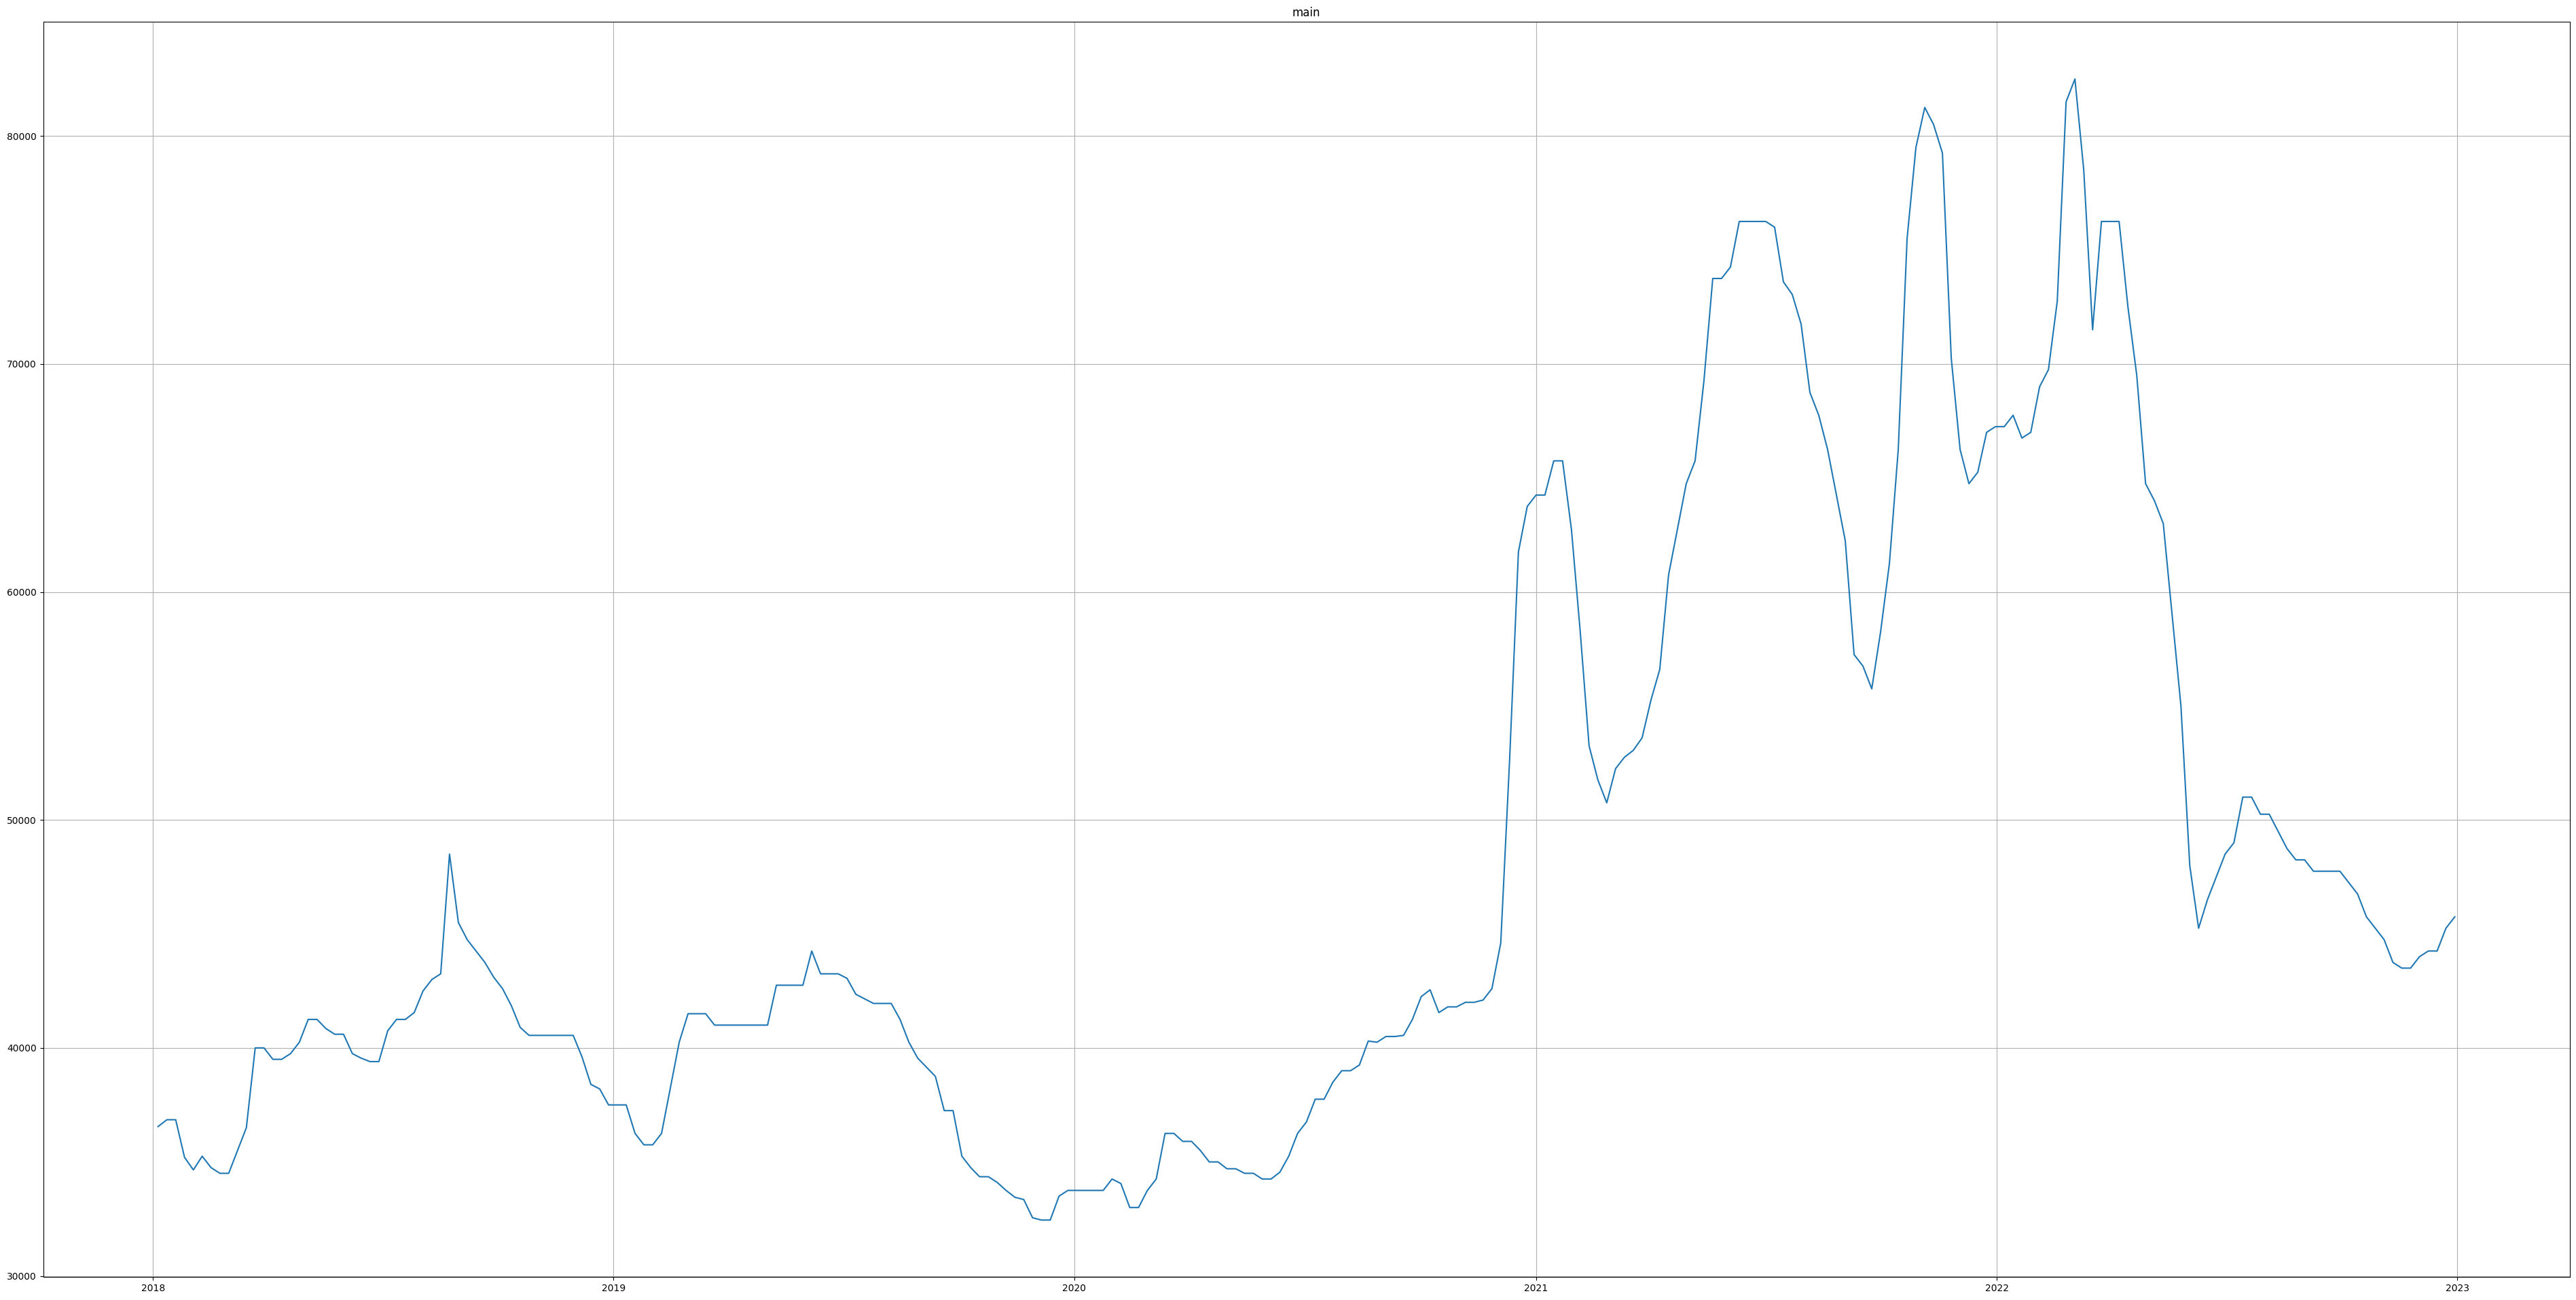

In [6]:
ts.plot(figsize=(48, 24))

# Catboost (Обучение модели и прогназирование)

Наш прогноз на данных

1.647716906133194
1.6356645839662867


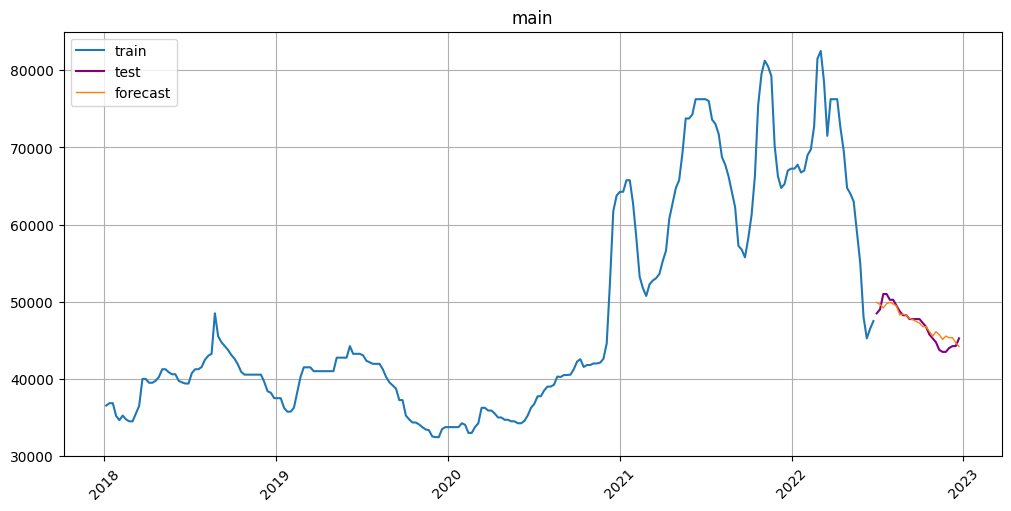

In [57]:
HORIZON = 26
mape = MAPE()
smape = SMAPE()
train_ts, test_ts = ts.train_test_split(
    train_start="2018-01-05",
    train_end="2022-06-30",
    test_start="2022-07-01",
    test_end="2022-12-23",
)
lags = LagTransform(in_column="target", lags=list(range(1, 94, 1)))
train_ts.fit_transform([lags])
model = CatBoostMultiSegmentModel(task_type='CPU')
model.fit(train_ts)
future_ts = train_ts.make_future(HORIZON)
forecast_ts = model.forecast(future_ts)
train_ts.inverse_transform()
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=261)
print(mape(y_true=test_ts, y_pred=forecast_ts)['main'])
print(smape(y_true=test_ts, y_pred=forecast_ts)['main'])

# CUDA

Проверка доступны ли ядра cuda для вычислений на них

In [8]:
import torch

print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device:{torch.cuda.current_device()}")
		
print(f"Name of current CUDA device:{torch.cuda.get_device_name(cuda_id)}")
print(f"How many devices {torch.cuda.device_count()}")

Is CUDA supported by this system? True
CUDA version: 11.7
ID of current CUDA device:0
Name of current CUDA device:NVIDIA GeForce RTX 2070 Super
How many devices 1


# Обработка предсказаний

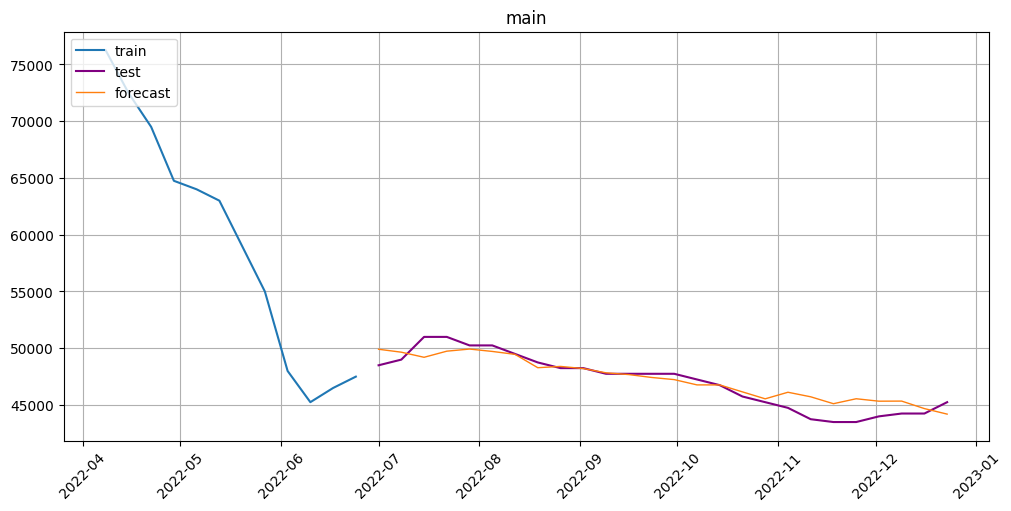

In [58]:
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=12)

In [59]:
test_df = test_ts.to_pandas(True)
forecast_df = forecast_ts.to_pandas(True)[['timestamp','target','segment']]

In [60]:
test_df

,timestamp,target,segment
0,2022-07-01,48500.0,main
1,2022-07-08,49000.0,main
2,2022-07-15,51000.0,main
3,2022-07-22,51000.0,main
4,2022-07-29,50250.0,main
5,2022-08-05,50250.0,main
6,2022-08-12,49500.0,main
7,2022-08-19,48750.0,main
8,2022-08-26,48250.0,main
9,2022-09-02,48250.0,main


In [61]:
forecast_df

,timestamp,target,segment
0,2022-07-01,49912.365665,main
1,2022-07-08,49653.219844,main
2,2022-07-15,49203.803102,main
3,2022-07-22,49742.720897,main
4,2022-07-29,49929.000408,main
5,2022-08-05,49719.686198,main
6,2022-08-12,49462.145706,main
7,2022-08-19,48286.191139,main
8,2022-08-26,48399.115868,main
9,2022-09-02,48212.471825,main


In [62]:
result_df = test_df.copy()
result_df

,timestamp,target,segment
0,2022-07-01,48500.0,main
1,2022-07-08,49000.0,main
2,2022-07-15,51000.0,main
3,2022-07-22,51000.0,main
4,2022-07-29,50250.0,main
5,2022-08-05,50250.0,main
6,2022-08-12,49500.0,main
7,2022-08-19,48750.0,main
8,2022-08-26,48250.0,main
9,2022-09-02,48250.0,main


In [63]:
for_res = pd.Series(forecast_df['target'])
for_res

0     49912.365665
1     49653.219844
2     49203.803102
3     49742.720897
4     49929.000408
5     49719.686198
6     49462.145706
7     48286.191139
8     48399.115868
9     48212.471825
10    47835.716395
11    47682.528917
12    47428.326911
13    47237.348247
14    46772.209735
15    46770.428653
16    46156.353878
17    45545.602841
18    46124.333004
19    45723.971833
20    45115.315864
21    45551.487375
22    45337.097365
23    45344.977682
24    44685.202682
25    44197.699031
Name: target, dtype: float64

# Выведение итогов

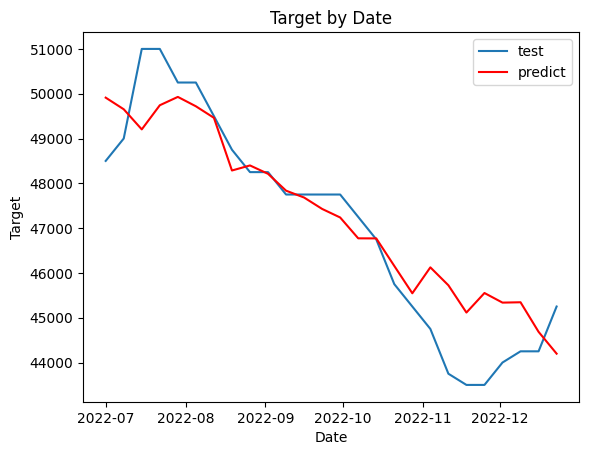

In [55]:
# plt.figure(figsize=(32, 12))
plt.plot(test_df['timestamp'], test_df['target'], label='test' )
plt.plot(forecast_df['timestamp'], forecast_df['target'], color='red', label='predict')

plt.title('Target by Date')
plt.xlabel('Date')
plt.ylabel('Target')

plt.legend()

plt.show() 